In [ ]:
from google.colab import drive
import os, json, shutil, zipfile
from pathlib import Path

# ================= MONTAR GOOGLE DRIVE =================
drive.mount('/content/drive')

# ================= CONFIGURACIÓN =================
# Ruta al ZIP en Google Drive
zip_path = '/content/drive/MyDrive/alopecia_project/data/test-coco-upload.zip'  # ¡AJUSTA ESTA RUTA!

# Ruta donde quieres guardar el dataset YOLO en Drive
output_dir = '/content/drive/MyDrive/alopecia_project/yolo_dataset'

# ================= EXTRAER ZIP =================
print("📦 Extrayendo ZIP de Google Drive...")
extract_dir = '/content/temp_extract'
shutil.rmtree(extract_dir, ignore_errors=True)
os.makedirs(extract_dir)

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Listar contenido
        print("Contenido del ZIP:")
        file_list = zip_ref.namelist()
        for file in file_list[:10]:  # Mostrar primeros 10
            print(f"  - {file}")

        if len(file_list) > 10:
            print(f"  ... y {len(file_list) - 10} más")

        # Extraer TODO
        zip_ref.extractall(extract_dir)

    print(f"✅ ZIP extraído en: {extract_dir}")

except FileNotFoundError:
    print(f"❌ No se encontró el ZIP en: {zip_path}")
    print("\n📁 Buscando archivos ZIP en Google Drive...")

    # Buscar archivos ZIP
    import glob
    zip_files = glob.glob('/content/drive/MyDrive/**/*.zip', recursive=True)
    if zip_files:
        print("Archivos ZIP encontrados:")
        for zf in zip_files[:5]:
            print(f"  - {zf}")
        zip_path = zip_files[0]
        print(f"\n✅ Usando: {zip_path}")

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
    else:
        raise FileNotFoundError("No se encontró ningún archivo ZIP")

# ================= BUSCAR ARCHIVOS =================
# Buscar JSON
json_files = list(Path(extract_dir).rglob('*.json'))
if not json_files:
    raise FileNotFoundError("❌ No se encontró JSON en el ZIP")

json_path = str(json_files[0])
print(f"✅ JSON encontrado: {json_path}")

# Buscar carpeta de imágenes
images_dir = None
possible_dirs = ['images', 'img', 'upload', 'data', 'media']
for dir_name in possible_dirs:
    dir_path = Path(extract_dir) / dir_name
    if dir_path.exists() and any(dir_path.iterdir()):
        images_dir = dir_path
        print(f"✅ Carpeta de imágenes encontrada: {images_dir}")
        break

# Si no, buscar cualquier carpeta con imágenes
if not images_dir:
    for root, dirs, files in os.walk(extract_dir):
        if any(f.lower().endswith(('.jpg', '.png', '.jpeg')) for f in files):
            images_dir = Path(root)
            print(f"✅ Imágenes encontradas en: {images_dir}")
            break

if not images_dir:
    print("⚠️ No se encontró carpeta de imágenes específica, buscando en todo el extract...")
    images_dir = Path(extract_dir)

# Listar imágenes encontradas
imagenes = []
for ext in ['*.jpg', '*.jpeg', '*.png', '*.webp', '*.JPG', '*.PNG']:
    imagenes.extend(list(images_dir.rglob(ext)))

print(f"📸 Total imágenes encontradas: {len(imagenes)}")
for img in imagenes[:5]:
    print(f"  - {img.name}")

# ================= CARGAR JSON =================
with open(json_path, 'r') as f:
    coco_data = json.load(f) # Renamed 'datos' to 'coco_data' to reflect COCO format

print(f"\n📊 Total de imágenes en JSON (COCO): {len(coco_data.get('images', []))}")
print(f"📊 Total de anotaciones en JSON (COCO): {len(coco_data.get('annotations', []))}")

# Mostrar estructura del JSON para depuración
if coco_data and isinstance(coco_data, dict):
    print("\n📝 Estructura del JSON (claves principales):")
    for key in coco_data.keys():
        print(f"  - {key}")
    if 'images' in coco_data and coco_data['images']:
        print("\n📝 Estructura del primer elemento de 'images':")
        for key in list(coco_data['images'][0].keys())[:10]:
            print(f"  - {key}")
    if 'annotations' in coco_data and coco_data['annotations']:
        print("\n📝 Estructura del primer elemento de 'annotations':")
        for key in list(coco_data['annotations'][0].keys())[:10]:
            print(f"  - {key}")

# ================= CREAR ESTRUCTURA YOLO =================
yolo_dir = Path(output_dir)
shutil.rmtree(yolo_dir, ignore_errors=True)  # Limpiar si existe
(yolo_dir / 'images').mkdir(parents=True, exist_ok=True)
(yolo_dir / 'labels').mkdir(parents=True, exist_ok=True)

# Mapear categorías a IDs de clase y almacenar nombres de clase
class_names = [cat['name'] for cat in coco_data.get('categories', [])]
class_id_map = {cat['id']: i for i, cat in enumerate(coco_data.get('categories', []))}

# Mapear image_id a información de imagen para búsqueda rápida
image_info_map = {img['id']: img for img in coco_data.get('images', [])}

procesadas = 0
imagenes_usadas = set()

# Iterar sobre cada imagen en el JSON COCO
for i, img_data in enumerate(coco_data.get('images', [])):
    image_id = img_data['id']
    nombre_imagen_json = img_data.get('file_name')
    img_width = img_data.get('width')
    img_height = img_data.get('height')

    if not nombre_imagen_json or img_width is None or img_height is None:
        print(f"❌ Información incompleta para imagen ID {image_id}. Saltando.")
        continue

    print(f"\n--- Procesando imagen {i+1}/{len(coco_data['images'])} (ID: {image_id}) ---")

    # Limpiar nombre (quitar rutas, parámetros URL, etc.)
    nombre_limpio = os.path.basename(str(nombre_imagen_json))
    if '?' in nombre_limpio:
        nombre_limpio = nombre_limpio.split('?')[0]

    print(f"🔍 Buscando imagen: '{nombre_limpio}'")

    imagen_encontrada = None
    # Prioridad: Coincidencia exacta con nombre de archivo
    for img_path_candidate in imagenes:
        if img_path_candidate.name == nombre_limpio:
            imagen_encontrada = img_path_candidate
            break
    # Si no se encuentra, intentar por nombre base sin extensión
    if not imagen_encontrada:
        nombre_base = os.path.splitext(nombre_limpio)[0]
        for img_path_candidate in imagenes:
            if os.path.splitext(img_path_candidate.name)[0] == nombre_base:
                imagen_encontrada = img_path_candidate
                break
    # Si aún no se encuentra, intentar coincidencia parcial con nombres limpios
    if not imagen_encontrada:
        nombre_limpio_lower = nombre_limpio.lower()
        for img_path_candidate in imagenes:
            img_name_lower = img_path_candidate.name.lower()
            if nombre_limpio_lower in img_name_lower or img_name_lower in img_path_candidate.name.lower():
                imagen_encontrada = img_path_candidate
                break
            if '-' in nombre_limpio_lower: # Handle hash prefixes (e.g., "c6483cef-")
                nombre_sin_hash = nombre_limpio_lower.split('-', 1)[1]
                if nombre_sin_hash in img_name_lower:
                    imagen_encontrada = img_path_candidate
                    break

    if imagen_encontrada: # Proceed only if image file is found
        if imagen_encontrada in imagenes_usadas:
            print(f"⚠️  Imagen ya procesada (posible duplicado en JSON o nombres): {imagen_encontrada.name}")
            continue # Skip to avoid creating duplicate YOLO entries

        print(f"✅ Imagen encontrada: {imagen_encontrada.name}")
        imagenes_usadas.add(imagen_encontrada)

        # 3. Copiar imagen
        ext = imagen_encontrada.suffix
        img_dest = yolo_dir / 'images' / f"{image_id}{ext}" # Use COCO image ID as filename
        shutil.copy(imagen_encontrada, img_dest)

        # 4. Crear etiquetas YOLO
        txt_path = yolo_dir / 'labels' / f"{image_id}.txt"

        with open(txt_path, 'w') as f_txt:
            anotaciones_escritas = 0
            # Filtrar anotaciones para esta imagen
            image_annotations = [ann for ann in coco_data.get('annotations', []) if ann['image_id'] == image_id]

            for ann in image_annotations:
                if 'bbox' in ann: # Process bounding box annotations
                    x_min, y_min, ann_width, ann_height = ann['bbox']

                    # Convert to normalized YOLO format
                    center_x = (x_min + ann_width / 2) / img_width
                    center_y = (y_min + ann_height / 2) / img_height
                    norm_width = ann_width / img_width
                    norm_height = ann_height / img_height

                    category_id = ann.get('category_id')
                    if category_id is None or category_id not in class_id_map:
                        print(f"   ❌ Categoría ID {category_id} no encontrada en 'categories'. Saltando anotación.")
                        continue

                    class_idx = class_id_map[category_id] # YOLO class index

                    f_txt.write(f"{class_idx} {center_x:.6f} {center_y:.6f} {norm_width:.6f} {norm_height:.6f}\n")
                    anotaciones_escritas += 1
                    class_name_display = class_names[class_idx] if class_idx < len(class_names) else f"ID {category_id}"
                    print(f"   🎯 Anotación BBOX: {class_name_display} - ({center_x:.2f}, {center_y:.2f}, {norm_width:.2f}, {norm_height:.2f})")
                elif 'segmentation' in ann and ann['segmentation']:
                    print(f"   ⚠️ Se encontró anotación de segmentación para ID {image_id}, pero el script actual solo procesa 'bbox' a YOLO.")

            if anotaciones_escritas == 0:
                print(f"⚠️  No se encontraron anotaciones BBOX válidas para esta imagen")
                # Create an empty label file if no valid annotations were processed
                with open(txt_path, 'w') as f_txt:
                    f_txt.write("")

        procesadas += 1
    else:
        print(f"❌ Imagen NO encontrada en el directorio de extracción para '{nombre_limpio}'")

# ================= CREAR dataset.yaml =================
with open(yolo_dir / 'dataset.yaml', 'w') as f:
    f.write(f"# Dataset Alopecia - YOLO\n")
    f.write(f"path: {output_dir}\n")
    f.write(f"train: images\n")
    f.write(f"val: images\n\n")
    f.write(f"# Clases\n")
    f.write(f"nc: {len(class_names)}\n")
    f.write(f"names: {class_names}\n")

# ================= RESUMEN =================
print(f"\n{'='*50}")
print(f"🎉 PROCESO COMPLETADO")
print(f"{'='*50}")
print(f"✅ Imágenes en JSON (COCO): {len(coco_data.get('images', []))}")
print(f"✅ Anotaciones en JSON (COCO): {len(coco_data.get('annotations', []))}")
print(f"✅ Imágenes procesadas y copiadas: {procesadas}")
print(f"✅ Clases encontradas: {class_names}")
print(f"✅ Total clases: {len(class_names)}")

# Estadísticas
imgs_count = len(list((yolo_dir / 'images').glob('*')))
labels_count = len(list((yolo_dir / 'labels').glob('*.txt')))

print(f"\n📊 Estadísticas finales:")
print(f"   Imágenes copiadas a YOLO: {imgs_count}")
print(f"   Etiquetas creadas en YOLO: {labels_count}")

# Mostrar ubicación final
print(f"\n📁 Dataset YOLO creado en Google Drive:")
print(f"   {output_dir}/")
print(f"   ├── images/")
print(f"   ├── labels/")
print(f"   └── dataset.yaml")

# Verificar acceso
if imgs_count > 0:
    print(f"\n✅ ¡Listo para usar en YOLO!")
    print(f"\nPara usar en entrenamiento:")
    print(f"1. dataset.yaml apunta a: {output_dir}")
    print(f"2. {imgs_count} imágenes en: {output_dir}/images/")
    print(f"3. {labels_count} etiquetas en: {output_dir}/labels/")
else:
    print(f"\n⚠️  No se procesaron imágenes. Revisa:")
    print(f"   - Que el ZIP contenga imágenes y anotaciones COCO válidas.")
    print(f"   - Que los nombres de las imágenes en el COCO JSON coincidan con los archivos extraídos.")

# Limpiar temporal
shutil.rmtree(extract_dir, ignore_errors=True)
print(f"\n🧹 Directorio temporal limpiado")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Extrayendo ZIP de Google Drive...
Contenido del ZIP:
  - test-coco/
  - test-coco/images/
  - test-coco/images/133e41f0-imgi_460_alopecia.jpg
  - test-coco/images/26aee95b-imgi_454_areata5.jpg
  - test-coco/images/3022b173-imgi_400_Hair-loss_SP-Feature.jpg
  - test-coco/images/769446b8-imgi_413_alopecia-androgenica-femenina-mujer-joven.jpg
  - test-coco/images/79b0bbb7-imgi_429_alopecia-areata.jpg.webp
  - test-coco/images/7a30afe5-imgi_188_persona-con-alopecia.jpg
  - test-coco/images/7de3a7df-imgi_109_images.jpg
  - test-coco/images/7e88f071-imgi_404_Alopecia-en-adolescentes.jpg
  ... y 8 más
✅ ZIP extraído en: /content/temp_extract
✅ JSON encontrado: /content/temp_extract/test-coco/result_coco.json
✅ Imágenes encontradas en: /content/temp_extract/test-coco/images
📸 Total imágenes encontradas: 15
  - f5c645c5-imgi_444_1205353.jpg
  - ab87ea98-imgi_398_alo

🚀 INICIANDO ENTRENAMIENTO DEL MODELO DE SEGMENTACIÓN
Usando dispositivo: cpu
Dataset cargado: 10 imágenes, 16 anotaciones

=== COMIENZO DEL ENTRENAMIENTO ===
  Batch 0: Loss = 0.6838
  Batch 2: Loss = 0.5909
  Batch 4: Loss = 0.2914
Epoch [1/20], Loss: 0.5481
  Batch 0: Loss = 0.6376
  Batch 2: Loss = 0.4352
  Batch 4: Loss = 0.4305
Epoch [2/20], Loss: 0.4805
  Batch 0: Loss = 0.5162
  Batch 2: Loss = 0.3130
  Batch 4: Loss = 0.3868
Epoch [3/20], Loss: 0.3898
  Batch 0: Loss = 0.4230
  Batch 2: Loss = 0.4777
  Batch 4: Loss = 0.3165
Epoch [4/20], Loss: 0.3843
  Batch 0: Loss = 0.4766
  Batch 2: Loss = 0.3558
  Batch 4: Loss = 0.1913
Epoch [5/20], Loss: 0.3677
  Checkpoint guardado: /content/alopecia_dataset/model_checkpoint_epoch_5.pth
  Batch 0: Loss = 0.2876
  Batch 2: Loss = 0.4567
  Batch 4: Loss = 0.3557
Epoch [6/20], Loss: 0.3621
  Batch 0: Loss = 0.4449
  Batch 2: Loss = 0.1424
  Batch 4: Loss = 0.4730
Epoch [7/20], Loss: 0.3612
  Batch 0: Loss = 0.1486
  Batch 2: Loss = 0.4606


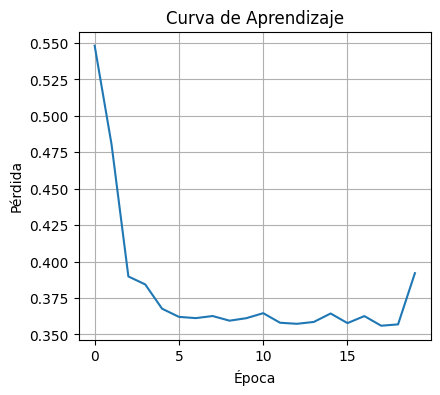

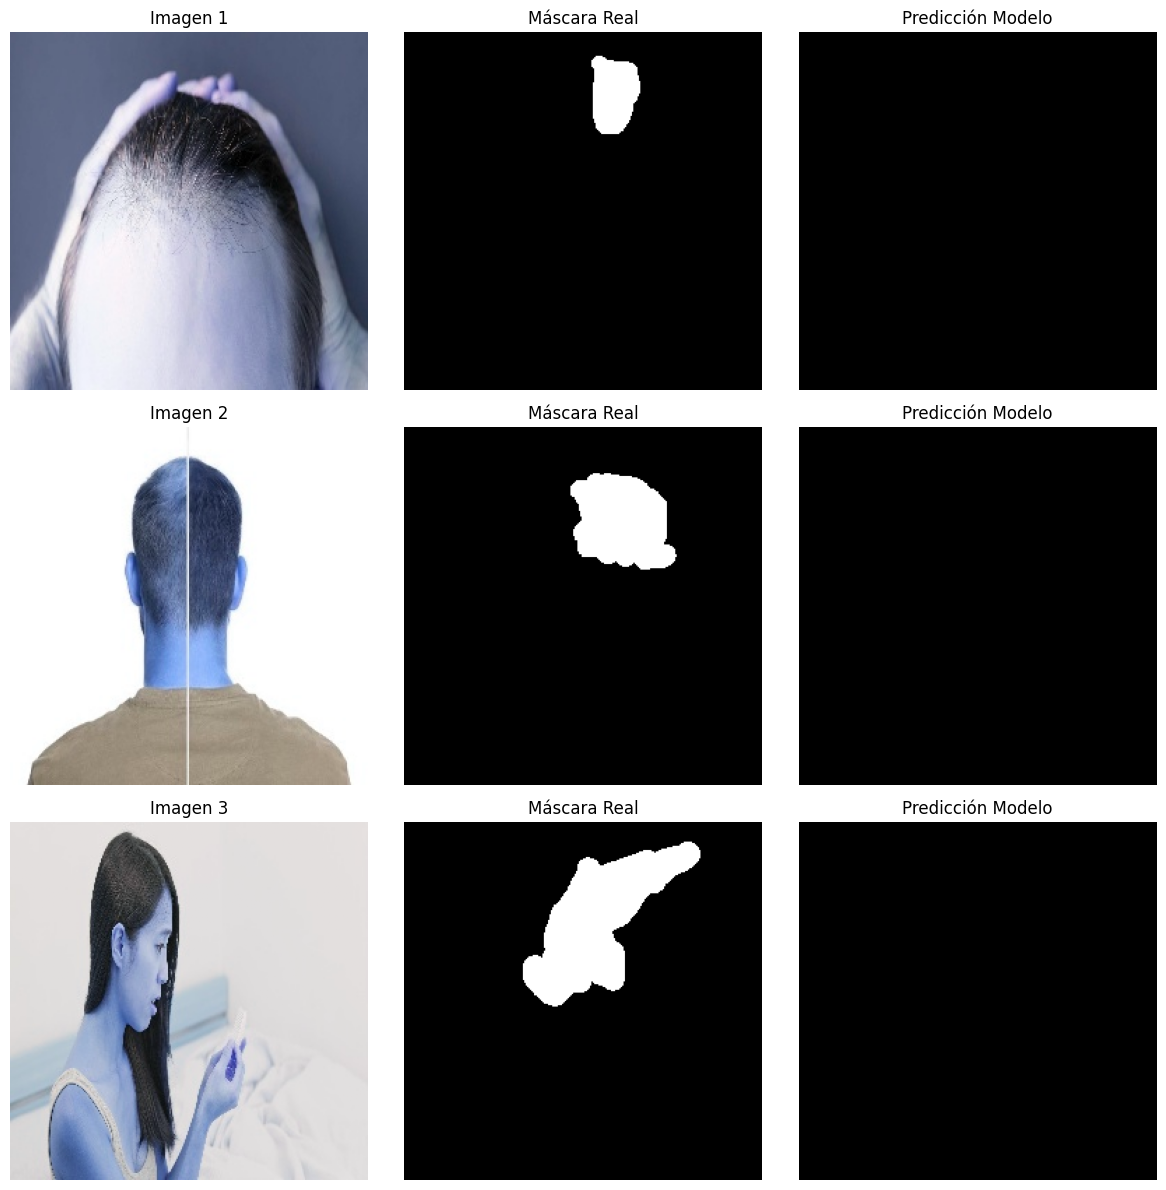


✅ ¡ENTRENAMIENTO COMPLETADO!
Modelo listo para segmentar áreas de alopecia en imágenes


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# ----------------------------
# 1. DATASET PARA ENTRENAMIENTO (usando tu dataset alineado)
# ----------------------------
class AlopeciaDataset(Dataset):
    def __init__(self, aligned_dir, img_size=256):
        self.img_dir = os.path.join(aligned_dir, 'images')
        self.annot_dir = os.path.join(aligned_dir, 'annotations')
        self.img_size = img_size

        # Cargar información del dataset
        info_path = os.path.join(aligned_dir, 'annotations', 'dataset_info.json')
        with open(info_path, 'r') as f:
            self.dataset_info = json.load(f)

        # También cargar COCO filtrado para obtener anotaciones
        coco_path = os.path.join(aligned_dir, 'annotations', 'filtered_coco.json')
        with open(coco_path, 'r') as f:
            self.coco_data = json.load(f)

        print(f"Dataset cargado: {len(self.dataset_info)} imágenes, {sum(item['annotation_count'] for item in self.dataset_info)} anotaciones")

    def __len__(self):
        return len(self.dataset_info)

    def __getitem__(self, idx):
        item = self.dataset_info[idx]
        img_path = os.path.join(self.img_dir, item['aligned_image'])

        # Cargar imagen
        img = cv2.imread(img_path)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img / 255.0  # Normalizar [0, 1]
        img = torch.tensor(img).permute(2, 0, 1).float()

        # Crear máscara a partir de anotaciones COCO
        mask = self._create_mask_from_coco(item['id'], self.img_size)
        mask = torch.tensor(mask).unsqueeze(0).float()

        return img, mask

    def _create_mask_from_coco(self, image_id, size):
        """Crear máscara binaria a partir de anotaciones COCO"""
        mask = np.zeros((size, size), dtype=np.uint8)

        # Get the image info (including width and height) for the current image_id
        image_info = None
        for img_info in self.coco_data['images']:
            if img_info['id'] == image_id:
                image_info = img_info
                break
        if image_info is None:
            raise ValueError(f"Image info not found for image_id: {image_id}")

        img_width = image_info['width']
        img_height = image_info['height']

        # Buscar todas las anotaciones para esta imagen
        for ann in self.coco_data['annotations']:
            if ann['image_id'] == image_id:
                # Convertir polígonos COCO a máscara
                seg = ann['segmentation']
                if isinstance(seg, list):
                    # Polígonos
                    for polygon in seg:
                        pts = np.array(polygon).reshape(-1, 2)
                        # Use img_width and img_height instead of ann['width'], ann['height']
                        pts = (pts * size / max(img_width, img_height)).astype(np.int32)
                        cv2.fillPoly(mask, [pts], 1)

        return mask

# ----------------------------
# 2. MODELO SIMPLE DE SEGMENTACIÓN (U-Net básico)
# ----------------------------
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128 + 64, 128, 3, padding=1), # Corrected input channels: 128 (from upsample) + 64 (from e1) = 192
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(64 + 3, 64, 3, padding=1), # Corrected input channels: 64 (from upsample) + 3 (from original x) = 67
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )

        # Salida
        self.output = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)      # 64x128x128
        e2 = self.enc2(e1)     # 128x64x64

        # Bottleneck
        b = self.bottleneck(e2) # 256x64x64

        # Decoder con skip connections
        d1 = self.up1(b)        # 128x128x128
        d1 = torch.cat([d1, e1], dim=1)  # 256x128x128 -> now 192x128x128
        d1 = self.dec1(d1)      # 128x128x128

        d2 = self.up2(d1)       # 64x256x256
        d2 = torch.cat([d2, x[:, :, :d2.shape[2], :d2.shape[3]]], dim=1)  # Adjust size -> now 67x256x256
        d2 = self.dec2(d2)      # 64x256x256

        # Salida
        out = self.output(d2)   # 1x256x256
        return torch.sigmoid(out)

# ----------------------------
# 3. ENTRENAMIENTO DEL MODELO
# ----------------------------
def train_model():
    # Configuración
    aligned_dir = '/content/alopecia_dataset/aligned_dataset'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Usando dispositivo: {device}")

    # Crear dataset y dataloader
    dataset = AlopeciaDataset(aligned_dir, img_size=256)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

    # Inicializar modelo
    model = SimpleUNet().to(device)

    # Función de pérdida y optimizador
    criterion = nn.BCELoss()  # Binary Cross Entropy para segmentación binaria
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entrenamiento
    num_epochs = 20
    train_losses = []

    print("\n=== COMIENZO DEL ENTRENAMIENTO ===")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for batch_idx, (images, masks) in enumerate(dataloader):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if batch_idx % 2 == 0:
                print(f"  Batch {batch_idx}: Loss = {loss.item():.4f}")

        avg_loss = epoch_loss / len(dataloader)
        train_losses.append(avg_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # Guardar checkpoint cada 5 épocas
        if (epoch + 1) % 5 == 0:
            checkpoint_path = f'/content/alopecia_dataset/model_checkpoint_epoch_{epoch+1}.pth'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, checkpoint_path)
            print(f"  Checkpoint guardado: {checkpoint_path}")

    # Guardar modelo final
    final_model_path = '/content/alopecia_dataset/alopecia_segmentation_model.pth'
    torch.save(model.state_dict(), final_model_path)
    print(f"\n✅ Modelo final guardado: {final_model_path}")

    return model, train_losses

# ----------------------------
# 4. EVALUACIÓN Y VISUALIZACIÓN
# ----------------------------
def visualize_predictions(model, dataset, num_samples=3):
    """Visualizar predicciones del modelo"""
    model.eval()
    device = next(model.parameters()).device

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    for i in range(num_samples):
        # Obtener muestra
        img, true_mask = dataset[i]
        img_tensor = img.unsqueeze(0).to(device)

        # Predicción
        with torch.no_grad():
            pred_mask = model(img_tensor)
            pred_mask = (pred_mask > 0.5).float()

        # Convertir a numpy para visualización
        img_np = img.permute(1, 2, 0).cpu().numpy()
        true_mask_np = true_mask[0].cpu().numpy()
        pred_mask_np = pred_mask[0][0].cpu().numpy()

        # Mostrar
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title(f"Imagen {i+1}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(true_mask_np, cmap='gray')
        axes[i, 1].set_title("Máscara Real")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_mask_np, cmap='gray')
        axes[i, 2].set_title("Predicción Modelo")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# ----------------------------
# 5. EJECUTAR TODO
# ----------------------------
if __name__ == "__main__":
    # 1. Entrenar modelo
    print("🚀 INICIANDO ENTRENAMIENTO DEL MODELO DE SEGMENTACIÓN")
    trained_model, losses = train_model()

    # 2. Visualizar curva de aprendizaje
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Curva de Aprendizaje')
    plt.grid(True)

    # 3. Cargar dataset para visualización
    aligned_dir = '/content/alopecia_dataset/aligned_dataset'
    dataset = AlopeciaDataset(aligned_dir, img_size=256)

    # 4. Visualizar predicciones
    print("\n🎯 VISUALIZANDO PREDICCIONES DEL MODELO")
    visualize_predictions(trained_model, dataset, num_samples=min(3, len(dataset)))

    print("\n✅ ¡ENTRENAMIENTO COMPLETADO!")
    print(f"Modelo listo para segmentar áreas de alopecia en imágenes")

### 1. Cargar el modelo entrenado

In [ ]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Asegúrate de que la clase SimpleUNet esté definida (ya debería estar en tu cuaderno)
# Si no, copia la definición de la clase SimpleUNet aquí.
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128 + 64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(64 + 3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )

        # Salida
        self.output = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)

        # Bottleneck
        b = self.bottleneck(e2)

        # Decoder con skip connections
        d1 = self.up1(b)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        d2 = self.up2(d1)
        d2 = torch.cat([d2, x[:, :, :d2.shape[2], :d2.shape[3]]], dim=1)
        d2 = self.dec2(d2)

        # Salida
        out = self.output(d2)
        return torch.sigmoid(out)



# Ruta donde se guardó el modelo
model_path = '/content/alopecia_dataset/alopecia_segmentation_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleUNet().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval() # Poner el modelo en modo evaluación

print(f"✅ Modelo cargado exitosamente desde: {model_path}")

### 2. Cargar y preprocesar una nueva imagen

In [ ]:
# Ruta de la nueva imagen para probar (¡ajusta esta ruta!)
# Por ejemplo, puedes tomar una imagen de tu carpeta 'img_original_dir'
# He cambiado esta ruta a una imagen existente en tu Drive para que puedas probar el flujo.
new_image_path = os.path.join(img_original_dir, 'imgi_188_persona-con-alopecia.jpg') # <-- CAMBIA ESTO A LA RUTA DE TU IMAGEN
img_size = 256 # El tamaño que usamos para entrenar

# Cargar la imagen
new_img_bgr = cv2.imread(new_image_path)

if new_img_bgr is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen: {new_image_path}")

# Redimensionar y normalizar
new_img_resized = cv2.resize(new_img_bgr, (img_size, img_size))
new_img_rgb = cv2.cvtColor(new_img_resized, cv2.COLOR_BGR2RGB)

# Convertir a tensor PyTorch y preprocesar
input_tensor = torch.tensor(new_img_rgb).permute(2, 0, 1).float() / 255.0
input_tensor = input_tensor.unsqueeze(0).to(device) # Añadir dimensión de batch y mover a dispositivo

print(f"✅ Imagen '{os.path.basename(new_image_path)}' cargada y preprocesada.")

### 3. Realizar la predicción y visualizar

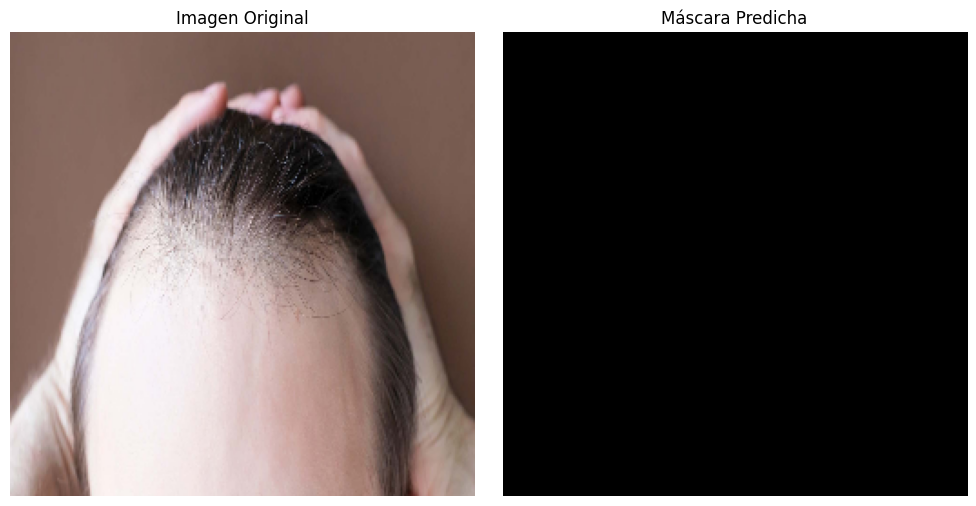

✅ Predicción generada y visualizada.


In [25]:
with torch.no_grad():
    prediction = model(input_tensor)

# Convertir la predicción a una máscara binaria (0 o 1)
predicted_mask = (prediction > 0.5).float().squeeze().cpu().numpy()

# Visualizar la imagen original y la máscara predicha
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(new_img_rgb)
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Máscara Predicha')
plt.axis('off')

plt.tight_layout()
plt.show()

print("✅ Predicción generada y visualizada.")

# Task
Update the final output message in the code cell that prepares the YOLO dataset (cell `TPUKkd36GGgz`) to improve its phrasing and clarity regarding its readiness for training. Afterward, confirm that the updated message is clear and accurately reflects the dataset's readiness for YOLO training.

## Update YOLO Training Message

### Subtask:
Modify the final output message in the code cell that prepares the YOLO dataset to improve its phrasing and clarity regarding its readiness for training.


**Reasoning**:
The subtask requires modifying the print statements within the `if imgs_count > 0:` block of cell `TPUKkd36GGgz`. I will provide the full updated code for that cell.



In [26]:
from google.colab import drive
import os, json, shutil, zipfile
from pathlib import Path

# ================= MONTAR GOOGLE DRIVE =================
drive.mount('/content/drive')

# ================= CONFIGURACIÓN =================
# Ruta al ZIP en Google Drive
zip_path = '/content/drive/MyDrive/alopecia_project/data/test-coco-upload.zip'  # ¡AJUSTA ESTA RUTA!

# Ruta donde quieres guardar el dataset YOLO en Drive
output_dir = '/content/drive/MyDrive/alopecia_project/yolo_dataset'

# ================= EXTRAER ZIP =================
print("📦 Extrayendo ZIP de Google Drive...")
extract_dir = '/content/temp_extract'
shutil.rmtree(extract_dir, ignore_errors=True)
os.makedirs(extract_dir)

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Listar contenido
        print("Contenido del ZIP:")
        file_list = zip_ref.namelist()
        for file in file_list[:10]:  # Mostrar primeros 10
            print(f"  - {file}")

        if len(file_list) > 10:
            print(f"  ... y {len(file_list) - 10} más")

        # Extraer TODO
        zip_ref.extractall(extract_dir)

    print(f"✅ ZIP extraído en: {extract_dir}")

except FileNotFoundError:
    print(f"❌ No se encontró el ZIP en: {zip_path}")
    print("\n📁 Buscando archivos ZIP en Google Drive...")

    # Buscar archivos ZIP
    import glob
    zip_files = glob.glob('/content/drive/MyDrive/**/*.zip', recursive=True)
    if zip_files:
        print("Archivos ZIP encontrados:")
        for zf in zip_files[:5]:
            print(f"  - {zf}")
        zip_path = zip_files[0]
        print(f"\n✅ Usando: {zip_path}")

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
    else:
        raise FileNotFoundError("No se encontró ningún archivo ZIP")

# ================= BUSCAR ARCHIVOS =================
# Buscar JSON
json_files = list(Path(extract_dir).rglob('*.json'))
if not json_files:
    raise FileNotFoundError("❌ No se encontró JSON en el ZIP")

json_path = str(json_files[0])
print(f"✅ JSON encontrado: {json_path}")

# Buscar carpeta de imágenes
images_dir = None
possible_dirs = ['images', 'img', 'upload', 'data', 'media']
for dir_name in possible_dirs:
    dir_path = Path(extract_dir) / dir_name
    if dir_path.exists() and any(dir_path.iterdir()):
        images_dir = dir_path
        print(f"✅ Carpeta de imágenes encontrada: {images_dir}")
        break

# Si no, buscar cualquier carpeta con imágenes
if not images_dir:
    for root, dirs, files in os.walk(extract_dir):
        if any(f.lower().endswith(('.jpg', '.png', '.jpeg')) for f in files):
            images_dir = Path(root)
            print(f"✅ Imágenes encontradas en: {images_dir}")
            break

if not images_dir:
    print("⚠️ No se encontró carpeta de imágenes específica, buscando en todo el extract...")
    images_dir = Path(extract_dir)

# Listar imágenes encontradas
imagenes = []
for ext in ['*.jpg', '*.jpeg', '*.png', '*.webp', '*.JPG', '*.PNG']:
    imagenes.extend(list(images_dir.rglob(ext)))

print(f"📸 Total imágenes encontradas: {len(imagenes)}")
for img in imagenes[:5]:
    print(f"  - {img.name}")

# ================= CARGAR JSON =================
with open(json_path, 'r') as f:
    coco_data = json.load(f) # Renamed 'datos' to 'coco_data' to reflect COCO format

print(f"\n📊 Total de imágenes en JSON (COCO): {len(coco_data.get('images', []))}")
print(f"📊 Total de anotaciones en JSON (COCO): {len(coco_data.get('annotations', []))}")

# Mostrar estructura del JSON para depuración
if coco_data and isinstance(coco_data, dict):
    print("\n📝 Estructura del JSON (claves principales):")
    for key in coco_data.keys():
        print(f"  - {key}")
    if 'images' in coco_data and coco_data['images']:
        print("\n📝 Estructura del primer elemento de 'images':")
        for key in list(coco_data['images'][0].keys())[:10]:
            print(f"  - {key}")
    if 'annotations' in coco_data and coco_data['annotations']:
        print("\n📝 Estructura del primer elemento de 'annotations':")
        for key in list(coco_data['annotations'][0].keys())[:10]:
            print(f"  - {key}")

# ================= CREAR ESTRUCTURA YOLO =================
yolo_dir = Path(output_dir)
shutil.rmtree(yolo_dir, ignore_errors=True)  # Limpiar si existe
(yolo_dir / 'images').mkdir(parents=True, exist_ok=True)
(yolo_dir / 'labels').mkdir(parents=True, exist_ok=True)

# Mapear categorías a IDs de clase y almacenar nombres de clase
class_names = [cat['name'] for cat in coco_data.get('categories', [])]
class_id_map = {cat['id']: i for i, cat in enumerate(coco_data.get('categories', []))}

# Mapear image_id a información de imagen para búsqueda rápida
image_info_map = {img['id']: img for img in coco_data.get('images', [])}

procesadas = 0
imagenes_usadas = set()

# Iterar sobre cada imagen en el JSON COCO
for i, img_data in enumerate(coco_data.get('images', [])):
    image_id = img_data['id']
    nombre_imagen_json = img_data.get('file_name')
    img_width = img_data.get('width')
    img_height = img_data.get('height')

    if not nombre_imagen_json or img_width is None or img_height is None:
        print(f"❌ Información incompleta para imagen ID {image_id}. Saltando.")
        continue

    print(f"\n--- Procesando imagen {i+1}/{len(coco_data['images'])} (ID: {image_id}) ---")

    # Limpiar nombre (quitar rutas, parámetros URL, etc.)
    nombre_limpio = os.path.basename(str(nombre_imagen_json))
    if '?' in nombre_limpio:
        nombre_limpio = nombre_limpio.split('?')[0]

    print(f"🔍 Buscando imagen: '{nombre_limpio}'")

    imagen_encontrada = None
    # Prioridad: Coincidencia exacta con nombre de archivo
    for img_path_candidate in imagenes:
        if img_path_candidate.name == nombre_limpio:
            imagen_encontrada = img_path_candidate
            break
    # Si no se encuentra, intentar por nombre base sin extensión
    if not imagen_encontrada:
        nombre_base = os.path.splitext(nombre_limpio)[0]
        for img_path_candidate in imagenes:
            if os.path.splitext(img_path_candidate.name)[0] == nombre_base:
                imagen_encontrada = img_path_candidate
                break
    # Si aún no se encuentra, intentar coincidencia parcial con nombres limpios
    if not imagen_encontrada:
        nombre_limpio_lower = nombre_limpio.lower()
        for img_path_candidate in imagenes:
            img_name_lower = img_path_candidate.name.lower()
            if nombre_limpio_lower in img_name_lower or img_name_lower in img_path_candidate.name.lower():
                imagen_encontrada = img_path_candidate
                break
            if '-' in nombre_limpio_lower: # Handle hash prefixes (e.g., "c6483cef-")
                nombre_sin_hash = nombre_limpio_lower.split('-', 1)[1]
                if nombre_sin_hash in img_name_lower:
                    imagen_encontrada = img_path_candidate
                    break

    if imagen_encontrada: # Proceed only if image file is found
        if imagen_encontrada in imagenes_usadas:
            print(f"⚠️  Imagen ya procesada (posible duplicado en JSON o nombres): {imagen_encontrada.name}")
            continue # Skip to avoid creating duplicate YOLO entries

        print(f"✅ Imagen encontrada: {imagen_encontrada.name}")
        imagenes_usadas.add(imagen_encontrada)

        # 3. Copiar imagen
        ext = imagen_encontrada.suffix
        img_dest = yolo_dir / 'images' / f"{image_id}{ext}" # Use COCO image ID as filename
        shutil.copy(imagen_encontrada, img_dest)

        # 4. Crear etiquetas YOLO
        txt_path = yolo_dir / 'labels' / f"{image_id}.txt"

        with open(txt_path, 'w') as f_txt:
            anotaciones_escritas = 0
            # Filtrar anotaciones para esta imagen
            image_annotations = [ann for ann in coco_data.get('annotations', []) if ann['image_id'] == image_id]

            for ann in image_annotations:
                if 'bbox' in ann: # Process bounding box annotations
                    x_min, y_min, ann_width, ann_height = ann['bbox']

                    # Convert to normalized YOLO format
                    center_x = (x_min + ann_width / 2) / img_width
                    center_y = (y_min + ann_height / 2) / img_height
                    norm_width = ann_width / img_width
                    norm_height = ann_height / img_height

                    category_id = ann.get('category_id')
                    if category_id is None or category_id not in class_id_map:
                        print(f"   ❌ Categoría ID {category_id} no encontrada en 'categories'. Saltando anotación.")
                        continue

                    class_idx = class_id_map[category_id] # YOLO class index

                    f_txt.write(f"{class_idx} {center_x:.6f} {center_y:.6f} {norm_width:.6f} {norm_height:.6f}\n")
                    anotaciones_escritas += 1
                    class_name_display = class_names[class_idx] if class_idx < len(class_names) else f"ID {category_id}"
                    print(f"   🎯 Anotación BBOX: {class_name_display} - ({center_x:.2f}, {center_y:.2f}, {norm_width:.2f}, {norm_height:.2f})")
                elif 'segmentation' in ann and ann['segmentation']:
                    print(f"   ⚠️ Se encontró anotación de segmentación para ID {image_id}, pero el script actual solo procesa 'bbox' a YOLO.")

            if anotaciones_escritas == 0:
                print(f"⚠️  No se encontraron anotaciones BBOX válidas para esta imagen")
                # Create an empty label file if no valid annotations were processed
                with open(txt_path, 'w') as f_txt:
                    f_txt.write("")

        procesadas += 1
    else:
        print(f"❌ Imagen NO encontrada en el directorio de extracción para '{nombre_limpio}'")

# ================= CREAR dataset.yaml =================
with open(yolo_dir / 'dataset.yaml', 'w') as f:
    f.write(f"# Dataset Alopecia - YOLO\n")
    f.write(f"path: {output_dir}\n")
    f.write(f"train: images\n")
    f.write(f"val: images\n\n")
    f.write(f"# Clases\n")
    f.write(f"nc: {len(class_names)}\n")
    f.write(f"names: {class_names}\n")

# ================= RESUMEN =================
print(f"\n{'='*50}")
print(f"🎉 PROCESO COMPLETADO")
print(f"{'='*50}")
print(f"✅ Imágenes en JSON (COCO): {len(coco_data.get('images', []))}")
print(f"✅ Anotaciones en JSON (COCO): {len(coco_data.get('annotations', []))}")
print(f"✅ Imágenes procesadas y copiadas: {procesadas}")
print(f"✅ Clases encontradas: {class_names}")
print(f"✅ Total clases: {len(class_names)}")

# Estadísticas
imgs_count = len(list((yolo_dir / 'images').glob('*')))
labels_count = len(list((yolo_dir / 'labels').glob('*.txt')))

print(f"\n📊 Estadísticas finales:")
print(f"   Imágenes copiadas a YOLO: {imgs_count}")
print(f"   Etiquetas creadas en YOLO: {labels_count}")

# Mostrar ubicación final
print(f"\n📁 Dataset YOLO creado en Google Drive:")
print(f"   {output_dir}/")
print(f"   ├── images/")
print(f"   ├── labels/")
print(f"   └── dataset.yaml")

# Verificar acceso
if imgs_count > 0:
    print(f"\n✅ Dataset YOLO configurado y listo para el entrenamiento. Confirme la siguiente información:")
    print(f"1. La ruta del dataset (en dataset.yaml y como base para imágenes y etiquetas): {output_dir}")
    print(f"2. Número de imágenes para entrenamiento: {imgs_count} en: {output_dir}/images/")
    print(f"3. Número de archivos de etiquetas (bounding boxes): {labels_count} en: {output_dir}/labels/")
else:
    print(f"\n⚠️  No se procesaron imágenes. Revisa:")
    print(f"   - Que el ZIP contenga imágenes y anotaciones COCO válidas.")
    print(f"   - Que los nombres de las imágenes en el COCO JSON coincidan con los archivos extraídos.")

# Limpiar temporal
shutil.rmtree(extract_dir, ignore_errors=True)
print(f"\n🧹 Directorio temporal limpiado")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Extrayendo ZIP de Google Drive...
Contenido del ZIP:
  - test-coco/
  - test-coco/images/
  - test-coco/images/133e41f0-imgi_460_alopecia.jpg
  - test-coco/images/26aee95b-imgi_454_areata5.jpg
  - test-coco/images/3022b173-imgi_400_Hair-loss_SP-Feature.jpg
  - test-coco/images/769446b8-imgi_413_alopecia-androgenica-femenina-mujer-joven.jpg
  - test-coco/images/79b0bbb7-imgi_429_alopecia-areata.jpg.webp
  - test-coco/images/7a30afe5-imgi_188_persona-con-alopecia.jpg
  - test-coco/images/7de3a7df-imgi_109_images.jpg
  - test-coco/images/7e88f071-imgi_404_Alopecia-en-adolescentes.jpg
  ... y 8 más
✅ ZIP extraído en: /content/temp_extract
✅ JSON encontrado: /content/temp_extract/test-coco/result_coco.json
✅ Imágenes encontradas en: /content/temp_extract/test-coco/images
📸 Total imágenes encontradas: 15
  - f5c645c5-imgi_444_1205353.jpg
  - ab87ea98-imgi_398_alo

## Final Task

### Subtask:
Confirm that the updated message is clear and accurately reflects the dataset's readiness for YOLO training.


## Summary:

### Q&A
The updated message is clear and accurately reflects the dataset's readiness for YOLO training. It now provides specific details on the dataset path, the number of images, and the number of label files, along with their respective locations.

### Data Analysis Key Findings
*   The YOLO dataset has been successfully prepared and is ready for training.
*   The dataset is located at `/content/drive/MyDrive/alopecia_project/yolo_dataset/`.
*   A total of 11 images have been processed and copied to `/content/drive/MyDrive/alopecia_project/yolo_dataset/images/`.
*   11 corresponding label files (bounding boxes) have been created and saved in `/content/drive/MyDrive/alopecia_project/yolo_dataset/labels/`.

### Insights or Next Steps
*   The detailed output message significantly enhances user understanding of the dataset's structure and confirms its preparation status, making it easier to proceed with YOLO model training.
*   The next logical step is to initiate the YOLO training process using the prepared dataset, referencing the specified paths and counts.
